In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.signal
%matplotlib notebook

## Calculate a perfect Airy disc from a given NA
The theoretical point spread function from an imaging system consisting of a perfect thin lens is the diffraction pattern of a disc aperture.  From Goodman (pp. 76--8) we have the result that the amplitude in the sample plane is proportional to:
$$\left| \frac{J_1(2\pi\omega\rho)}{\pi\omega\rho}\right|^2$$
This is for the Fraunhofer diffraction pattern of a disc with radius $\omega$ as a function of spatial frequency $\rho=\sqrt{f^2_x + f^2_y}=kr/2\pi z$ where $k$ is the wavenumber, $r$ is radius in the sample, and $z$ is the distance from the aperture to the observation plane.  In our case, the aperture size $\omega$ is specified by the NA of the objective.  This is defined in terms of the angle of the rays farthest from the optical axis - $NA = n\sin\alpha$ where $\alpha$ is the angle between the edge rays and the optical axis, and $n$ is the refractive index of the immersion medium, here air ($n=1$) or oil ($n=1.52$ for $100\times$ objectives only).  As we are operating in the far-field approximation (because the objective lens is designed to perform a Fourier transform) As the wavenumber depends on refractive index ($k=nk_0$ where $k_0$ is wavenumber in vacuum).

## Calculate an edge response function from NA
To try and avoid any approximations at all, we could just do it numerically.  In this case, the image of an edge can be generated by creating an edge image (with a perfectly sharp edge) then cropping it to a disc in the Fourier plane, and transforming back to get the original edge.  As that image is a function only of x (and not y), the truncation in the Fourier plane might as well also be 1D.  That means that the line response (which should be the vertically-integrated Bessel function) can be calculated analytically as a sinc function, and the edge response should just be a convolution of that with the edge.

The line response function for a pupil that collects a maximum transverse wavenumber $k_p$ is:
$$lsf(x) = \int_{-\infty}^\infty P(k_x)e^{jk_xx}\mathrm{d}k_x = \int_{-k_p}^{k_p}e^{jk_xx}\mathrm{d}k_x \propto \frac{\sin(k_px)}{x}$$
We can integrate this to find the line response, but it's probably as easy to do that numerically.  It's worth noting that the image should be assymetric - because the two levels are zero and non-zero, fluctuations around zero will tend to be suppressed while those around the bright edge will appear bigger.

For an objective with $NA=1.3$, we would expect a PSF with $k_p=\frac{1.3\times2\pi}{\lambda}$ which in this case will be:

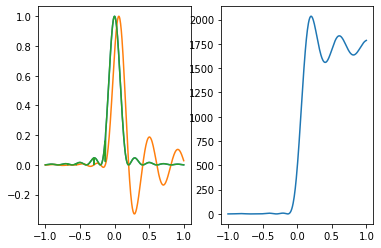

In [2]:
kp = 1.3 * 2 * np.pi/0.53 # for green light
x = np.linspace(-1, 1, 400)
dx = np.mean(np.diff(x))
lsf = np.sinc(kp * x / np.pi) # numpy defines sinc as sin(pi*x)/(pi*x) for some reason...
edge = np.cumsum(lsf)**2
recovered_lsf = np.diff([0] + list(edge))
recovered_lsf /= np.max(recovered_lsf)

# We can, of course, recover it more or less perfectly by taking a square root
# (the more or less part is because we get sign errors)
recovered_lsf_2 = np.diff([0] + list(edge**0.5))**2

f, ax = plt.subplots(1,2)
ax[0].plot(x, lsf**2)
ax[1].plot(x, edge)
ax[0].plot(x, recovered_lsf)
ax[0].plot(x, recovered_lsf_2)

Note that:
* The recovered line spread function from differentiating the edge is not the same as the true one, because we measure intensity (amplitude squared).  That also means:
    * The mid-point of the intensity is not the true position of the edge (again because of the squaring)
    * The "ringing" is only on the bright side of the edge, not the dark side.
* ``numpy.sinc`` has an extra factor of $\pi$ in it!
* The FWHM of the recovered lsf is something like $180\,$nm.  That is a little less than half what I'm seeing :(
* The maths above is correct for *fully coherent* light.  This is correct in the limit of low-NA illumination in the microscope.  Fully incoherent light requires a larger illumination NA than collection NA (i.e. a very impressive oil-immersion condenser).  Realistically, though, this microscope has partially coherent illumination, as it does use a condenser lens with a non-zero NA.
* See J. W. Goocman, "Introduction to Fourier Optics", third edition, Chapter 6.2, pp135-138

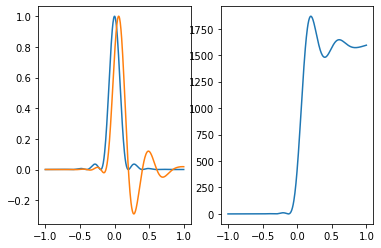

In [3]:
kps = 1.25 * 2 * np.pi/np.linspace(0.4,0.6, 100) # for green light (and a numerical aperture of 1.25)
x = np.linspace(-1, 1, 400)
dx = np.mean(np.diff(x))
lsf = np.zeros_like(x)
for kp in kps:
    lsf += np.sinc(kp * x / np.pi) # numpy defines sinc as sin(pi*x)/(pi*x) for some reason...
lsf /= float(len(kps))
edge = np.cumsum(lsf)**2
recovered_lsf = np.diff([0] + list(edge))
recovered_lsf /= np.max(recovered_lsf)

f, ax = plt.subplots(1,2)
ax[0].plot(x, lsf**2)
ax[1].plot(x, edge)
ax[0].plot(x, recovered_lsf)

# Analysis of real images
To compare this to experiment, I've taken lots of images of edges - generally as closely-spaced Z stacks, so that it's possible to be sure we've got the right plane.  The code below should load the (raw and JPEG) images.

The loaded array has shape: (2464, 3280, 3)


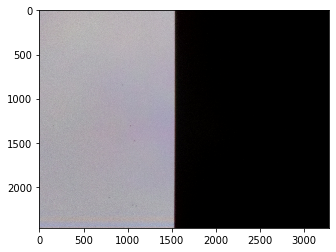

In [5]:
from extract_raw_image import load_raw_image
pi_bayer_array, jpeg, exif = load_raw_image("datasets/20180615_tanzania_characterisation/40x_plan_ac127_kohler/vertical_edge_zstack/image_010_x491859_y444923_z121551.jpg", open_jpeg=True) # 10-bit values in 16-bit integers
bayer = pi_bayer_array.array # this is a 3D array with 3 colour planes, but each colour plane includes only pixels with the relevant colour filter.
plt.figure()
plt.imshow(jpeg)
print("The loaded array has shape: {}".format(bayer.shape))

For ease of processing, we first flip/transpose the image so that it's always a vertical edge going from black to white, then fit a straight line to the edge so we can average along it.

[[0.   0.25 0.  ]
 [0.25 1.   0.25]
 [0.   0.25 0.  ]]


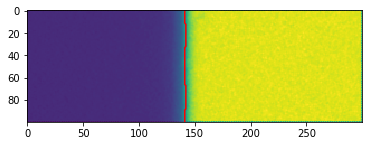

In [7]:
edge_slice = (slice(1182,1282), slice(1375,1675), slice(None)) #define the region we're looking at
raw_image = bayer[edge_slice]
kernel_rb = np.array([[1,2,1],
                      [2,4,2],
                      [1,2,1]])/4.0
kernel_g = np.array([[0,1,0],
                     [1,4,1],
                     [0,1,0]])/4.0
kernel = np.stack([kernel_rb, kernel_g, kernel_rb], axis=2)
demosaiced = scipy.signal.convolve(raw_image, kernel, mode="same")

from analyse_distortion import find_edge_orientation, find_edge, reduce_1d
from analyse_edge_image import locate_edge, reorient_image

# Ensure the images are black-white step functions
vertical, falling, line = locate_edge(demosaiced)
image = reorient_image(demosaiced, vertical, falling)
raw_image = reorient_image(raw_image, vertical, falling)

# Find the step in each row of the image, then fit a straight line
xs, ys = find_edge((image/4).sum(axis=2), fuzziness=10)
#line = np.polyfit(xs, ys, 1)

print(kernel[:,:,1])
plt.figure()
plt.imshow(image[:,:,1])
plt.plot(ys, xs, color="red")
#plt.plot(xs*line[0]+line[1], xs, color="white")

After arranging the image correctly and fitting the line, we average together the rows of the image.  These are first shifted (according to the line fitted in the previous step) to avoid blurring the line.  In fact, this allows us to do sub-pixel sampling, because a not-quite-vertical edge is not always in the same place relative to the pixel boundaries.

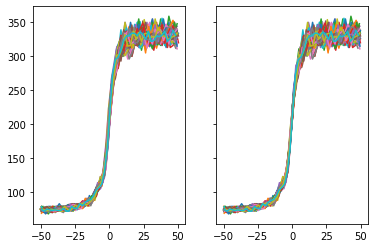

In [8]:
from analyse_edge_image import deduce_bayer_pattern

f, ax = plt.subplots(1,2, sharex=True, sharey=True)

def extract_aligned_edge(raw_image, width, channel=1, force_tx=None, thresholds=(0.25,0.75)):
    """Extract x, I coordinates for each row of the image, aligned to the edge
    
    raw_image should be an NxMx3 RGB image, with the dark-bright transition along the middle axis
    width will be the width of the output rows (should be less than the width of the raw image)
        NB this width is relative to the original image - as each row will only contain the 
        pixels with the selected colour, the rows will have half this many points.
    channel is the channel of the image to extract (0-2)
    thresholds specifies the region of I (relative to min/max)
    
    Return Value: [(x, I, tx)]
    x and I are cropped 1D arrays, each representing the x and I coordinates for one row.  The range of x
    will be approximately -widdth/2 to width/2, though there will usually be width/2 points.  tx is the 
    x coordinate where the transition was detected (i.e. the shift between the x coordinates and the pixels
    of the original image).
    """
    bayer = deduce_bayer_pattern(raw_image)[:,:,channel]
    aligned_rows = []
    for i in range(raw_image.shape[0]):
        row_bayer = bayer[i % bayer.shape[0], :]
        if np.any(row_bayer): # if there are active pixels of this channel in this row
            x = np.argmax(row_bayer) # find the position of the first relevant pixel in the row
            active_pixel_slice = slice(x, None, bayer.shape[1]) 
                # This slice object takes every other pixel, starting at x (x==0 or 1)

            # Extract the position and intensity of all of the pixels that are active
            x = np.arange(raw_image.shape[1])[active_pixel_slice]
            I = raw_image[i,active_pixel_slice,channel]

            # Crop out the part where it goes from black to white (from 25% to 75% intensity)
            normI = (I - np.min(I) + 0.0)/(np.max(I)-np.min(I)) # NB the +0.0 converts to floating point
            start = np.argmax(normI > thresholds[0])
            stop = np.argmax(normI > thresholds[1])

            # Fit a line and find the point where it crosses 0.5
            gradient, intercept = np.polyfit(x[start:stop], normI[start:stop], 1)
            transition_x = (0.5 - intercept)/gradient # 0.5 = intercept + gradient*xt
            
            # Now, crop out a region centered on the transition
            start = np.argmax(x > transition_x - width/2.0)
            #stop = np.argmax(x > transition_x + width/2.0)
            stop = start + width//row_bayer.shape[0] # Should do the same as above, but guarantees length.
            aligned_rows.append((x[start:stop] - transition_x, I[start:stop], transition_x))
    return aligned_rows
    
aligned_rows = extract_aligned_edge(raw_image, width=100, channel=1)
txs = np.array([tx for x, I, tx in aligned_rows])

for x, I, tx in aligned_rows:
    # Manually add back in the transition point shift to get un-aligned rows (!)
    ax[0].plot(x + tx - np.mean(txs), I)
    ax[1].plot(x, I)

The left plot shows the intensity (of the green channel) vs x position, while the right plot shows the same, but with a slight shift applied to each row so that they are aligned.  We've not done any resampling yet, just shifted the x coordinates.  NB the spacing between the points on this graph will be 2 pixels, because we only use pixels that have the correct colour Bayer filter on top of them.  If ``c==0 or 2`` (i.e. red/blue channels) we'll also only be plotting every other row.  Below, we plot the shift amount as a sanity check.

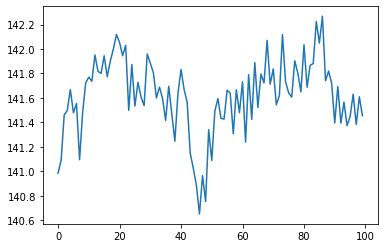

In [9]:
f, ax = plt.subplots(1)
ax.plot(txs)

If we're happy that the shifts are all vaguely sensible (I wouldn't expect them to vary by more than a few pixels from a straight line) we can start trying to average the lines together.  Below, we average all the points together with a moving window, currently with a width of two pixels (might decrease this).  The moving window looks pretty good for now.  The spline fit looks really good, and agrees well with the moving window, which gives me confidence it's working nicely.  It would be good to have a more rigorous way of choosing the number of knots, though.

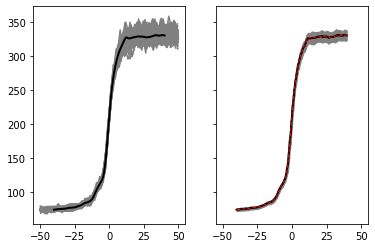

In [13]:
from scipy.interpolate import UnivariateSpline, LSQUnivariateSpline

def sorted_x_and_I(aligned_rows):
    """Extract all x and I coordinates from a set of rows, in ascending x order"""
    # First, extract the x and I coordinates into separate arrays and flatten them.
    xs, Is, txs = zip(*aligned_rows)
    all_x = np.array(xs).flatten()
    all_I = np.array(Is).flatten()

    # Points must be sorted in ascending order in x
    order = np.argsort(all_x)
    sorted_x = all_x[order]
    sorted_I = all_I[order]

    # If any points are the same, spline fitting fails - so add a little noise
    while np.any(np.diff(sorted_x) == 0):
        i = np.argmin(np.diff(sorted_x))
        sorted_x[i+1] += 0.0001 # 0.0001 is in units of pixels, i.e. insignificant.
    return sorted_x, sorted_I

def average_edge_spline(sorted_x, sorted_I, dx=0.1, knot_spacing=2.0, crop=10):
    """Average the edge, using a spline to smooth it.
    
    Returns an array of interpolated x coordinates and an array of correspoinding I values.
    """
    xmin, xmax = np.min(sorted_x), np.max(sorted_x)
    ks = knot_spacing
    spline = LSQUnivariateSpline(sorted_x, sorted_I, np.arange(xmin + ks, xmax - ks, ks))
    sx = np.arange(xmin + crop, xmax - crop, dx)
    return sx, spline(sx)

f, ax = plt.subplots(1,2, sharex=True, sharey=True)

aligned_rows = extract_aligned_edge(raw_image, width=100, channel=1)
for x, I, tx in aligned_rows:
    # Plot the aligned rows in the background
    ax[0].plot(x, I, color="gray")
    
sorted_x, sorted_I = sorted_x_and_I(aligned_rows)
spline_x, spline_I = average_edge_spline(sorted_x, sorted_I)
ax[0].plot(spline_x, spline_I, linewidth=2, color="black")

def average_edge_binning(sorted_x, sorted_I, dx=0.4, crop=10):
    """Bin points by their x values, and average each bin.
    
    sorted_x, sorted_I: data, in order of ascending x (flattened)
    dx: bin width, default=0.4.  Too small, and you get empty bins.
    crop: use this to ignore some pixels at the start/end.
    
    Return: x, I_mean, I_sd
    """
    xmin, xmax = np.min(sorted_x), np.max(sorted_x)
    binned_x = np.arange(xmin + crop, xmax - crop, dx)
    binned_I_mean = np.empty_like(binned_x)
    binned_I_sd = np.empty_like(binned_x)
    w = 2.0
    for i, x in enumerate(binned_x):
        rr = slice(np.argmax(sorted_x > x - w/2.0), 
                   np.argmax(sorted_x > x + w/2.0),)
        binned_I_mean[i] = np.mean(sorted_I[rr])
        binned_I_sd[i] = np.std(sorted_I[rr], ddof=1)
    return binned_x, binned_I_mean, binned_I_sd

binned_x, binned_I_mean, binned_I_sd = average_edge_binning(sorted_x, sorted_I)

ax[1].fill_between(binned_x, binned_I_mean - binned_I_sd, binned_I_mean + binned_I_sd, color="gray")
ax[1].plot(binned_x, binned_I_mean, linewidth=2, color="black")
ax[1].plot(spline_x, spline_I, linewidth=1, color="red", linestyle="--")


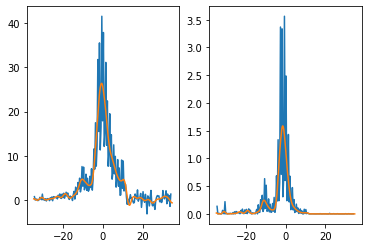

In [14]:
f, ax = plt.subplots(1,2, sharex=True, sharey=False)


def numerical_diff(x, y, crop=0, sqrt=False):
    """Numerically differentiate a vector of equally spaced values, with x
    
    Returns the mid-points of the x coordinates, and the numerically
    differentiated y values (scaled by the difference between x points).
    If a "crop" argument is supplied, it crops either end of the data by
    that amount (in units of x, rather than simply datapoints).
    """
    crop = np.argmax(x > np.min(x) + crop)
    if crop > 0:
        cropped_x = x[crop:-crop]
    mid_x = (cropped_x[1:] + cropped_x[:-1])/2.0

    if sqrt:
        diff_y = (np.diff((y - np.min(y))**0.5)/np.mean(np.diff(x)))**2
    else:
        diff_y = np.diff(y - np.min(y))/np.mean(np.diff(x))
    if crop > 0:
        diff_y = diff_y[crop:-crop]
        
    return mid_x, diff_y

ax[0].plot(*numerical_diff(binned_x, binned_I_mean, crop=5, sqrt=False))
ax[0].plot(*numerical_diff(spline_x, spline_I, crop=5, sqrt=False))
ax[1].plot(*numerical_diff(binned_x, binned_I_mean, crop=5, sqrt=True))
ax[1].plot(*numerical_diff(spline_x, spline_I, crop=5, sqrt=True))

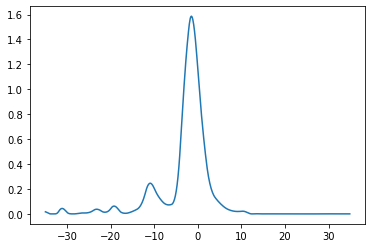

In [15]:
f, ax = plt.subplots(1,1)
ax.plot(*numerical_diff(spline_x, spline_I, crop=5, sqrt=True))

C:\Users\rwb34\dev\venvs\win-py3-scipy\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


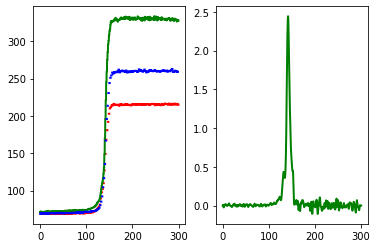

In [16]:
from analyse_edge_image import deduce_bayer_pattern

f, (ax, ax2) = plt.subplots(1,2)
subsampling = 10

def average_edge(image, line, subsampling=10, bayer_pattern=np.array([[[True]]])):
    """Average along an edge, returning a subsampled marginal distribution.
    
    image: the edge image to average.  Should be a vertical black-white edge.
        This should be a 3D numpy array - though the third dim may be length 1
    line: the coefficients of a straight line describing the edge - 2 elements
    subsampling: how many bins each pixel is divided into.
    bayer_pattern: 3D boolean array representing the Bayer pattern.  Default
        value will assume every pixel has valid values for every colour channel.
        
    Returns:
        subsampled_edge: a 2D array with the edge function for each colour.
        
    ==============
    Bayer patterns
    ==============
    * If bayer_pattern is None, we assume the camera has true RGB pixels.
    * If bayer_pattern is a scalar, it should be the side length of the unit
    cell of the Bayer pattern.  
    """
    xs = np.arange(image.shape[0]) # for convenience, X values of the image
    
    # We need to make the average wider than one line to allow shifting
    margin = subsampling * int(xs.shape[0]*np.abs(line[0]))//2 + 4*subsampling
    # To take the average, we need the sum and the number of terms:
    total_intensity = np.zeros((image.shape[1]*subsampling + 2*margin, image.shape[2]))
    total_n = np.zeros_like(total_intensity)
    bw, bh, n_channels = bayer_pattern.shape
    # Repeat the bayer pattern to make up a whole column (NB it's >1 row wide)
    bayer_col = np.tile(bayer_pattern, (1,image.shape[1]//bayer_pattern.shape[1]+1,1))
    bayer_col = bayer_col[:, :image.shape[1], :] # In case the image is not an integer number of cells
    
    # Calculate the shift for each line in the image
    y_shifts = -(xs - xs.shape[0]/2)*line[0] # Use the fitted line
    dys = np.round(y_shifts*subsampling).astype(int)
    for x, dy in zip(xs, dys):
        #y_shift = float(dy)/subsampling
        #ax.plot(np.arange(image.shape[1]/2)*2 + y_shift, image[x,(x % 2)::2,1])
        rr = slice(margin+dy, -margin+dy) # this aligns our row with the others
        total_intensity[rr,:] += np.repeat(image[x,:,:], subsampling, axis=0)
        total_n[rr] += np.repeat(bayer_col[x % bw, :, :], subsampling, axis=0)
    return total_intensity[margin:-margin, :] / total_n[margin:-margin, :]

bayer_pattern = deduce_bayer_pattern(raw_image, 2)
edge = average_edge(raw_image, line, bayer_pattern=bayer_pattern)
for i, col in enumerate(['r','g','b']):
    ys = np.arange(len(edge))/float(subsampling)
    ax.plot(ys, edge[:,i], linewidth=2, color=col)
    #ax2.plot(ys, scipy.ndimage.filters.gaussian_filter(edge[:,i], 0.5, order=1), linewidth=1, alpha=0.5, color=col)
for i, col in enumerate(['r','g','b']):
    ax2.plot(ys, scipy.ndimage.filters.gaussian_filter(edge[:,i], 10, order=1), linewidth=2, color=col)
    #ax2.plot(ys, scipy.ndimage.filters.median_filter(
    #                 scipy.ndimage.filters.gaussian_filter(edge[:,i], 0.5, order=1), (10)
    #        ), linewidth=2, color=col)

C:\Users\rwb34\dev\venvs\win-py3-scipy\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


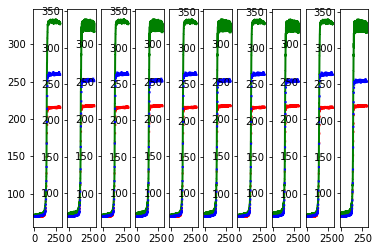

In [17]:
ss=10
f, axes = plt.subplots(1,ss)
for i, ax in enumerate(axes):
    edge = average_edge(raw_image[i:,:,:], line, bayer_pattern=bayer_pattern, subsampling=ss)
    for i, col in enumerate(['r','g','b']):
        ys = np.arange(len(edge))/float(ss)
        ax.plot(ys, edge[:,i], linewidth=2, color=col)

C:\Users\rwb34\dev\venvs\win-py3-scipy\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


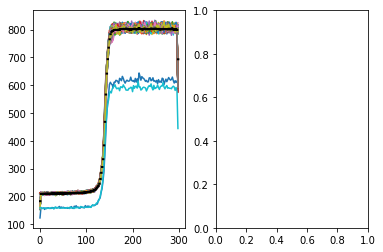

In [18]:
# This is an older version of average_edge that produced a pleasing plot...

f, (ax, ax2) = plt.subplots(1,2)
subsampling = 10

# We need to make the average wider than one line to allow shifting
margin = subsampling * int(xs.shape[0]*np.abs(line[0]))//2 + 4*subsampling
total_intensity = np.zeros(image.shape[1]*subsampling + 2*margin)
total_n = np.zeros_like(total_intensity)
y_shifts = -(xs - xs.shape[0]/2)*line[0] # Use the fitted line
#y_shifts += (xs % 2) # Compensate for diamond pattern
dys = np.round(y_shifts*subsampling).astype(int)
for x, dy in zip(xs, dys):
    y_shift = float(dy)/subsampling
    ax.plot(np.arange(image.shape[1]/2)*2 + y_shift, image[x,(x % 2)::2,1])
    for i in range(subsampling):
        rr = slice(margin+dy+i, -margin+dy+i, subsampling*2)
        total_intensity[rr] += image[x,(x%2)::2,1]
        total_n[rr] += 1
average_edge = total_intensity[margin:-margin] / total_n[margin:-margin]
ax.plot(np.arange(len(average_edge))/float(subsampling), average_edge, linewidth=2, color="black")

In [19]:
bp = np.zeros((2,2,3), dtype=np.bool)
bp[0,0,1]=True
bp[1,1,1]=True
bp[1,0,0]=True
bp[0,1,2]=True

np.repeat(np.tile(bp[0,:,:], (3,1)), 4, axis=0)


C:\Users\rwb34\dev\venvs\win-py3-scipy\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


array([[False,  True, False],
       [False,  True, False],
       [False,  True, False],
       [False,  True, False],
       [False, False,  True],
       [False, False,  True],
       [False, False,  True],
       [False, False,  True],
       [False,  True, False],
       [False,  True, False],
       [False,  True, False],
       [False,  True, False],
       [False, False,  True],
       [False, False,  True],
       [False, False,  True],
       [False, False,  True],
       [False,  True, False],
       [False,  True, False],
       [False,  True, False],
       [False,  True, False],
       [False, False,  True],
       [False, False,  True],
       [False, False,  True],
       [False, False,  True]])